# Exercise Sheet 4 - Segmentation & Denoising with U-Net

 * Deep Learning for Computer Vision - Winter Term 2023/24
 * Organizers: Anwai Archit, Sushmita Nair, Constantin Pape
 * Tutors: Ahsan Ali, Anwai Archit, Lukas Friedrich, Piklu Mallick, Sushmita Nair, Ayush Paliwal, Paul Wollenhaupt 
 * Due date: **Tuesday**, Dec 19, before 10:00

In this assignment we will use a U-Net for two different tasks:
- semantic segmentation of nuclei in microscopy images
- denoising of natural images

## Hints

The goal of the first part of the exercise (segmentation) is to implement the U-Net architecture very similar to the original publication and then use it for its initial purpose, semantic segmentation. In the second part we will use the same U-Net implementation, but use it for a different task: denoising, following the ideas of noise-to-noise. 

To understand the background of this exercise you can:

* Review the lecture (Lecture 5 for U-Net architecture, Lecture 6 for noise-to-noise)
* Read the [U-net publication](https://arxiv.org/abs/1505.04597).
* Read the [noise-to-noise publication](https://arxiv.org/abs/1803.04189).

Note that we will implement the same ideas as in these papers, but will deviate from the implementation details and conduct different and fewer experiments.
 
*Do not hesitate to ask questions and ideally discuss them with the fellow students on Rocket Chat! We will monitor the channel to provide you help if your discussions get stuck.*

### IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all the questions in written form**
- When you're done, download the notebook from Kaggle and **rename** it to `Tutorial_<X>_<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission for Homework 4`.
- Make only one submission of the exercise per group.
- The deadline is strict
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand.

Implementation
- Only change code to replace placeholders. Leave the other code as is. In addition to the python packages loaded below you are allowed to use any packages you want.


**Import required libraries.**

In [275]:
import os
import tqdm
import zipfile
import requests
from glob import glob
from pathlib import Path

import numpy as np
import seaborn as sns
import imageio.v2 as imageio
from matplotlib import colors
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage.measure import label
from skimage.util import random_noise
from scipy.optimize import linear_sum_assignment
from skimage.metrics import contingency_table, peak_signal_noise_ratio

**Temporary fix for importing `skimage.segmentation` on Kaggle**

As of 30th November 2023, Kaggle has an incompatible combination of the libraries `scipy` and `skimage.segmentation`. The latter is important for this exercise, so we provide you with a hack fix to it.

Note that this issue might be fixed by the time that you worked on the exercise (we informed kaggle about it, see https://github.com/Kaggle/docker-python/issues/1331). 

In [276]:
# let's check if the import works or not
#from skimage.segmentation import find_boundaries, watershed

If the issue still prevails in Kaggle, you will get an error statement:
```python
ImportError: cannot import name 'QhullError' from 'scipy.spatial' (/opt/conda/lib/python3.10/site-packages/scipy/spatial/__init__.py)
```

NOTE 1: If you don't get this error (or are not using kaggle), please skip the next two cells and continue with the exercise.

NOTE 2: If you do get this error, please run the next two cells. They will fix the import by modifying the python library directly.

In [277]:
# DO NOT CHANGE
def fix_scipy_imports(path="/opt/conda/lib/python3.10/site-packages/skimage/morphology/convex_hull.py"):
    with open(path, "r") as f:
        file = f.read()

    i = file.find("\n", 49)
    new_file = file[:i+1] + "# " + file[i+1:]

    with open(path, "w") as f:
        f.write(new_file)

In [278]:
# the issue should now be resolved. let's try it out.
try:
    from skimage.segmentation import find_boundaries, watershed
except ImportError:
    fix_scipy_imports()
    from skimage.segmentation import find_boundaries, watershed

**The normal exercise continues here.**

In [279]:
# create a root folder where to save the data for this exercise in Kaggle
root_folder = "/kaggle/working/dlforcv-ex4"
os.makedirs(root_folder, exist_ok=True)

## Segmentation

In the first part of the exercise we will implement the U-Net architecture and apply it to segment nuclei in fluorescence microscopy images. This is an important task in microscopy image analysis in order to identify and characterize cell morphology and dynamics. The data we are using is a subset of the [Kaggle Nucleus Segmentation challenge](https://www.kaggle.com/c/data-science-bowl-2018).

### Data preparation

In [280]:
# download the data
data_folder = os.path.join(root_folder, "kaggle-data")
url = "https://github.com/stardist/stardist/releases/download/0.1.0/dsb2018.zip"
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    tmp_path = os.path.join(data_folder, "data.zip")
    with requests.get(url) as r:
        with open(tmp_path, "wb") as f:
            f.write(r.content)
    with zipfile.ZipFile(tmp_path, "r") as f:
        f.extractall(data_folder)
    os.remove(tmp_path)
data_folder = os.path.join(data_folder, "dsb2018")
assert os.path.exists(data_folder)

**Data exploration**

The data is stored in the root folder `dsb2018` and contains the two subfolders `train` and `test` with train/test split. Each of these folders contains the folders `images` with the raw image data and `masks` with the instance masks. As a first step, we will visualize some of the images and labels from the training data.

In [281]:
image_paths = glob(os.path.join(data_folder, "train", "images", "*.tif"))
image_paths.sort()
mask_paths = glob(os.path.join(data_folder, "train", "masks", "*.tif"))
mask_paths.sort()
assert len(image_paths) == len(mask_paths)

In [282]:
# a function to generate a random color map for a label image
def get_random_colors(labels):
    n_labels = len(np.unique(labels)) - 1
    cmap = [[0, 0, 0]] + np.random.rand(n_labels, 3).tolist()
    cmap = colors.ListedColormap(cmap)
    return cmap

In [283]:
def plot_sample(image_path, mask_path):
    image, mask = imageio.imread(image_path), imageio.imread(mask_path)
    fig, ax = plt.subplots(1, 2)
    ax[0].axis("off")
    ax[0].imshow(image, cmap = "gray")
    # visualize the masks with random colors
    ax[1].axis("off")
    ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
    plt.show()

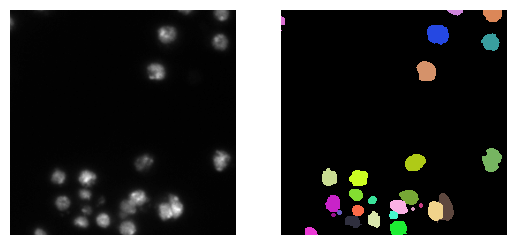

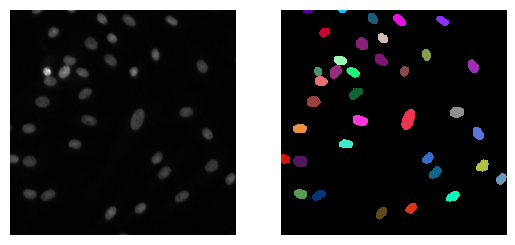

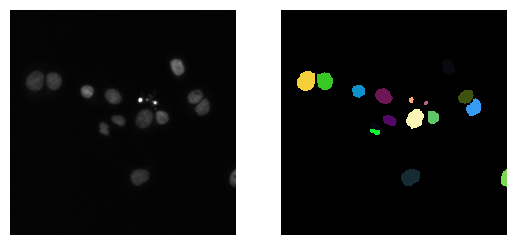

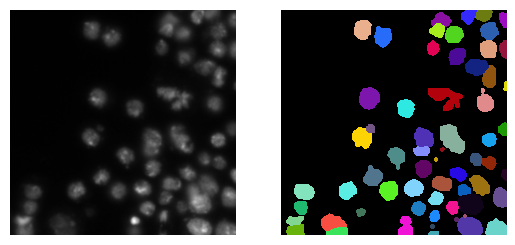

In [284]:
# plot the first 4 images
for i in range(4):
    plot_sample(image_paths[i], mask_paths[i])

You should see 4 images with nuclei and the corresponding colored nuclei masks. To further understand and explain the data, please answer the following **QUESTIONS**:
- Do the ids assigned to the individual nuclei (= colors in the 2nd image column) have a fixed meaning? In other words, would the segmentation meaningfully change if we change shuffle the ids, so that all pixels labeled `1` are labeled `2` and so on?
- Can we directly use a U-Net to predict the mask ids? Why / Why not?

TODO your answer here

In [285]:
# TODO find how many images we have in the training set

dataset_length = len(image_paths)
print("Length of the dataset:", dataset_length) # 447

# and find all (unique) shapes of the images in the training set

# Initialize an empty set to store unique shapes
unique_shapes = set()

# Iterate through the images and get their shapes
for image_path in image_paths:
    # Load the image
    image = imageio.imread(image_path)

    # Get the shape of the image and add it to the set
    unique_shapes.add(image.shape)

# Print the unique shapes
print("Unique shapes of the images in the training set:", unique_shapes)

Length of the dataset: 447
Unique shapes of the images in the training set: {(512, 640), (260, 347), (360, 360), (520, 696), (256, 256), (256, 320)}


**QUESTIONS**:
- Do all images have the same shape? If not, can this lead to problems?
- How could we deal with potential problems due to different image shapes?

TODO your answer here

In [286]:
# TODO now load the images and masks into memory, and normalize the images so that they have zero mean and unit variance
images = []
masks = []

# Iterate through the images and load them into memory
for image_path, mask_path in zip(image_paths, mask_paths):
    # Load the image and mask using imageio
    image = imageio.imread(image_path)
    mask = imageio.imread(mask_path)
    
    # Append the normalized image and mask to the lists
    images.append(image)
    masks.append(mask.astype("float32"))

# Print lengths of the lists
print("Length of images list:", len(images))
print("Length of masks list:", len(masks))

Length of images list: 447
Length of masks list: 447


In [287]:
ims_flat = np.concatenate([im.ravel() for im in images])
mean, std = np.mean(ims_flat), np.std(ims_flat)
images = [(im.astype("float32") - mean) / std for im in images]

print(mean,std)

14.423265754858166 19.57161020949301


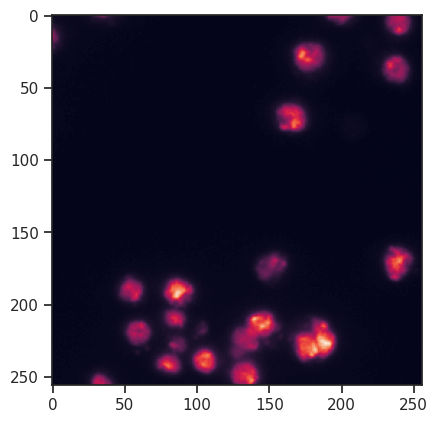

In [288]:
plt.imshow(images[0].squeeze())

In [289]:
# TODO make a train validation split, use every 20th image for validation
random_indices = list(range(447))
import random
random.shuffle(random_indices)
print(random_indices)

images = [images[i] for i in random_indices]
masks = [masks[i] for i in random_indices]

[348, 173, 265, 306, 126, 120, 360, 398, 136, 161, 274, 215, 429, 110, 177, 380, 91, 241, 414, 266, 152, 421, 187, 393, 185, 71, 320, 371, 237, 350, 279, 298, 271, 122, 4, 222, 349, 383, 164, 34, 365, 80, 20, 195, 41, 385, 142, 323, 305, 26, 83, 300, 332, 337, 373, 15, 127, 430, 22, 357, 221, 219, 118, 297, 209, 59, 6, 82, 37, 244, 280, 326, 281, 46, 252, 256, 38, 39, 330, 399, 285, 218, 146, 267, 254, 125, 230, 346, 7, 312, 419, 243, 211, 85, 176, 434, 247, 268, 121, 198, 424, 356, 197, 428, 140, 18, 417, 396, 389, 183, 119, 397, 184, 158, 98, 25, 387, 234, 294, 239, 388, 315, 144, 89, 412, 438, 51, 402, 2, 333, 376, 363, 64, 54, 49, 327, 141, 322, 227, 81, 404, 411, 75, 431, 231, 318, 377, 226, 384, 19, 196, 137, 42, 66, 117, 212, 420, 410, 368, 433, 31, 65, 328, 13, 240, 381, 108, 68, 72, 43, 369, 341, 347, 238, 362, 264, 134, 382, 79, 190, 181, 97, 93, 114, 101, 423, 103, 272, 179, 156, 56, 416, 353, 45, 446, 35, 269, 316, 175, 5, 342, 374, 253, 296, 248, 21, 422, 193, 261, 111, 11

In [290]:
train_images = []
train_masks = []
val_images = []
val_masks = []

for i, image in enumerate(images):
    if i % 20 == 0:
        val_images.append(image)
        val_masks.append(masks[i])
    else:
        train_images.append(image)
        train_masks.append(masks[i])
        
# Print lengths of the train and validation sets
print("Length of train_images list:", len(train_images))
print("Length of train_masks list:", len(train_masks))
print("Length of val_images list:", len(val_images))
print("Length of val_masks list:", len(val_masks))


Length of train_images list: 424
Length of train_masks list: 424
Length of val_images list: 23
Length of val_masks list: 23


In [291]:
# finally, let's choose the appropriate torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Implement PyTorch dataset**

As a next step, we implement a `torch.utils.data.Dataset` to access the data for training. As you should have realized in the previous question, the images in our training set come in different sizes. But in order to assemble images into batches we need images of the same size. To solve this issue, we will subsample patches of size 256 x 256 (smallest image size) from the images in the dataset.

In [292]:
class NucleiDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None, transform=None):
        assert len(images) == len(masks)
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.transform = transform

    def __getitem__(self, index):
        image, mask = self.images[index], self.masks[index]

        # crop the images to have the shape 256 x 256, so that we can feed them into memory
        # despite them having different sizes
        crop_shape = (256, 256)
        shape = image.shape
        if shape != crop_shape:
            assert image.ndim == mask.ndim == 2
            crop_start = [np.random.randint(0, sh - csh) if sh != csh else 0 for sh, csh in zip(shape, crop_shape)]
            crop = tuple(slice(cs, cs + csh) for cs, csh in zip(crop_start, crop_shape))
            image, mask = image[crop], mask[crop]
           
        # apply the transforms if given
        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
        if self.transform is not None:
            image, mask = self.transform(image, mask)
        
        # make sure we have numpy arrays and add a channel dimension for the image data
        #image, mask = np.array(image), np.array(mask)
        if image.ndim == 2:
            image = image[None]
            
        return image, mask
        
    def __len__(self):
        return len(self.images)
        

As discussed in the lecture, we can't learn the instance segmentation directly. So we will first start with a semantic segmentation problem and train the U-Net to distinguish foreground (nucleus) from background pixels. In other words, the network should predict for each pixel whether it belongs to a nucleus or to the background. To this end, implement a `mask_transform` that converts the instance segmentation ground-truth into a binary target and pass it to the training dataset.

In [293]:
# TODO implement a transform that outputs the binary target 
# and instantiate the training dataset and validation dataset with it
# HINT: the transform can be a function that takes the mask array as input and returns the binarized version
# HINT: you will also need to add a channel dimension to the target
# HINT: the targets need to be "float32" values (for the BCE Loss coming ahead)
from torchvision import transforms

def toTensor(image, mask):    
    transform = transforms.ToTensor()
    image = transform(image)
    mask = transform(mask)
    return image, mask


def mask_transform(mask):
    mask_binary = np.where(mask != 0, 1, mask)

    return mask_binary
    
train_dataset = NucleiDataset(train_images, train_masks, image_transform = None, mask_transform = mask_transform, transform = toTensor)
val_dataset =  NucleiDataset(val_images, val_masks, image_transform = None, mask_transform = mask_transform, transform = toTensor)

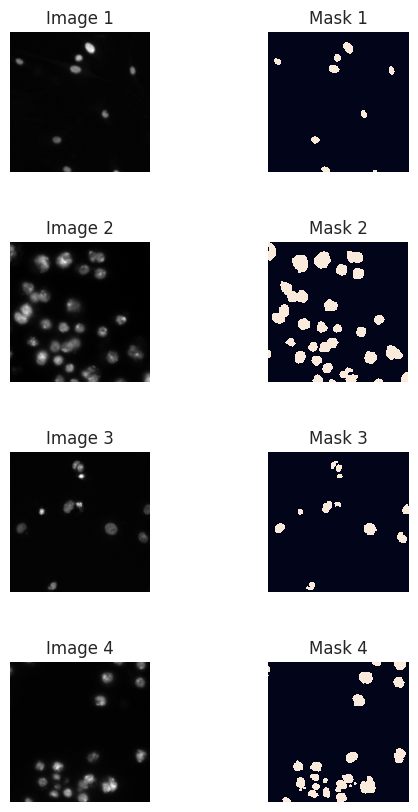

In [294]:
# TODO sample a few images from the dataset and verify that they are correct

fig, ax = plt.subplots(4, 2, figsize=(10, 10), gridspec_kw={'hspace': 0.5, 'wspace': -0.5})

# Draw random sample
for i in range(4):
    # Sample a random index
    sample_index = np.random.randint(len(train_dataset))

    # Get the image and mask
    image, mask = train_dataset[sample_index]

    # Plot the image
    ax[i, 0].axis("off")
    ax[i, 0].imshow(np.squeeze(image), cmap = "gray") #remove first dimension
    ax[i, 0].set_title(f"Image {i + 1}", fontsize=12)

    # Plot the mask
    ax[i, 1].axis("off")
    ax[i, 1].imshow(np.squeeze(mask), interpolation='none') #remove first dimension
    ax[i, 1].set_title(f"Mask {i + 1}", fontsize=12)

plt.show()


The images you sample should look similar to this (using the standard colormap for the binarized mask):
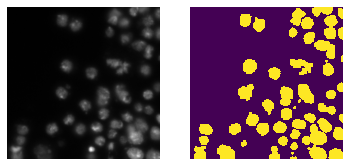

### Implement the U-Net

Next, we will implement a U-Net architecture inspired [Ronneberger et al.](https://arxiv.org/abs/1505.04597), see the image below.

IMPORTANT: unlike in the publication / image we will use SAME convolutions, so that the input shape is the same as the output shape. This will introduce some boundary artifacts, but it will make implementing the rest of this exercise much simpler.
It also means that you don't need to crop the features passed on in the skip connections and can directly concatenate them.

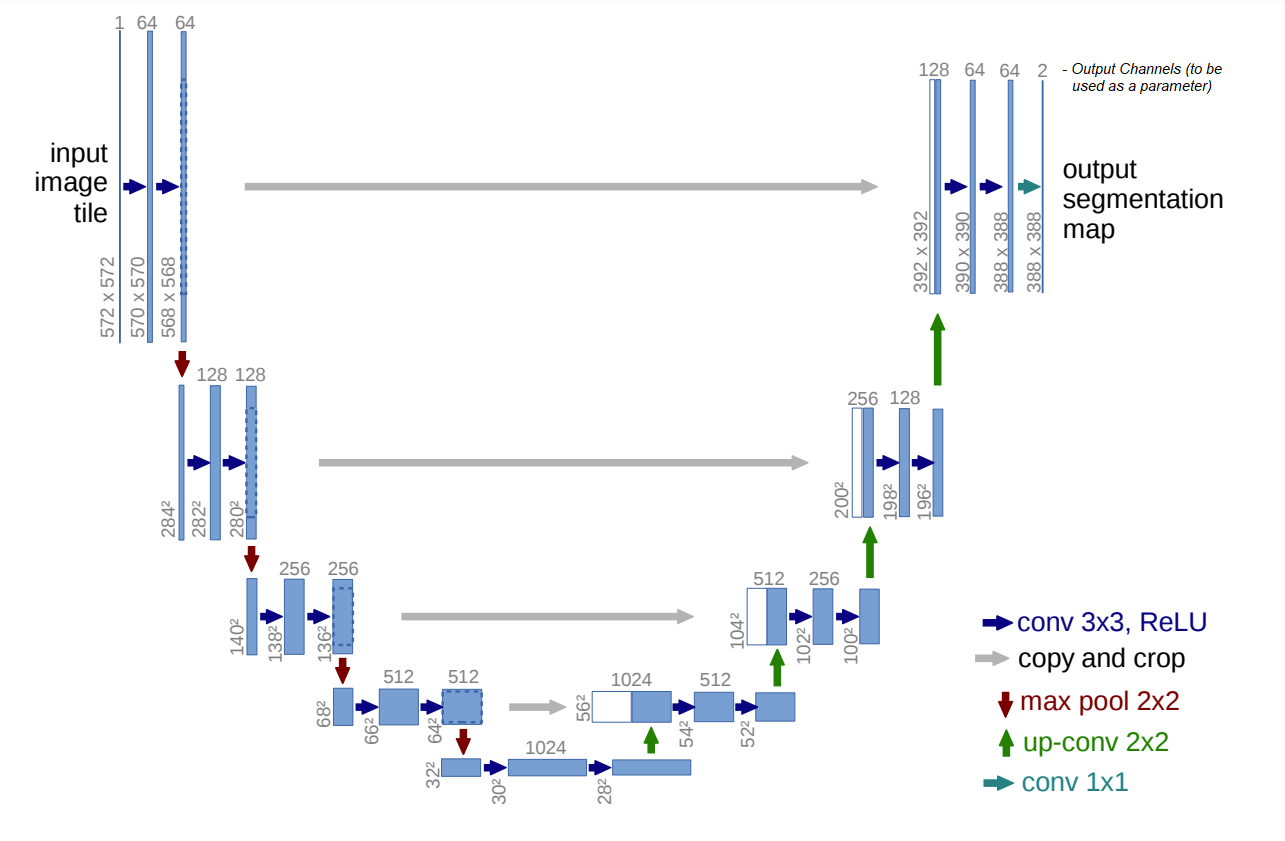

HINTS: 
- the `up-conv` used here is called [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#convtranspose2d) in PyTorch.
- you can concatenate the features coming from the skip connections and the encoder with `torch.cat`
- you will need `nn.ModuleList` to store the individual blocks of the encoder / decoder

Before you implement the U-Net, please answer the following QUESTIONS:
- What kind of architecture is the U-Net and what is the rationale behind this architecture?
- What other types of architectures for semantic segmentation exist to achieve similar effects?
- Why are the skip connections used in the U-Net?

TODO your answers here

In [295]:
# TODO implement the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        # Contraction/Downsampling path (ENCODER)
        self.first = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = 64, kernel_size = 3, padding = 'same'), # same padding (as given in exercise)
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.ReLU()
        )
        
        self.down1 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2),# default stride = 2
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 'same'),
            nn.ReLU()
        )
        
        self.down2 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 'same'),
            nn.ReLU()
        )
        
        self.down3 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 'same'),
            nn.ReLU()
        )
        
        self.lowest = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2) # Stride?
        )
        
        # Expansion/Upsampling (DECODER)
        self.up1 = nn.Sequential(
            nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2) # Stride?
        )
            
        self.up2 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2) # Stride?
        )
            
        self.up3 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2) # Stride?
        )
            
        self.last = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = out_channels, kernel_size = 1, padding = 'same')
        )
            
    def forward(self, x):
        
        x1 = self.first(x) 
        print(x1.shape)
        x2 = self.down1(x1)
        print(x2.shape)
        x3 = self.down2(x2)
        print(x3.shape)
        x4 = self.down3(x3)
        print(f"x4: {x4.shape}")
        
        x = self.lowest(x4)
        print(x.shape)
        
        x = torch.cat((x4, x))
        print(x.shape)
        x = self.up1(x)
        print(x.shape)
        
        x = torch.cat((x3, x))
        print(x.shape)
        x = self.up2(x)
        print(x.shape)
        
        x = torch.cat((x2, x))
        print(x.shape)
        x = self.up3(x)
        print(x.shape)
            
        x = torch.cat((x1,x))
        print(x.shape)
        x = self.last(x)
        print(x.shape)
        
        return x
            
 

In [296]:
# TODO instantiate a unet and check that your architecture is correct by applying it to
# an input from the train loader

image, mask = train_dataset[0]

model = UNet(in_channels = 1, out_channels = 1)
print(model)
output = model(image)


UNet(
  (first): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (down1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
  )
  (down2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
  )
  (down3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): ReLU()
    (3)

[[-0.06547689 -0.06616729 -0.06676482 ... -0.06643309 -0.06821973
  -0.0675182 ]
 [-0.06388984 -0.06494205 -0.06556138 ... -0.06743633 -0.06790922
  -0.06769343]
 [-0.06406926 -0.06469001 -0.06444625 ... -0.06635417 -0.06880806
  -0.06765319]
 ...
 [-0.0644142  -0.06469358 -0.06338774 ... -0.06640134 -0.06815132
  -0.06690158]
 [-0.06586634 -0.06597297 -0.06580438 ... -0.06667196 -0.06852633
  -0.06684049]
 [-0.06429634 -0.06486721 -0.06423169 ... -0.06424049 -0.06561906
  -0.06627507]]


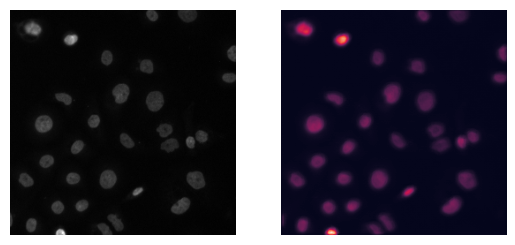

In [297]:
# TODO display the prediction. Can you interpret the resulting image?

output_copy = output.detach().numpy()
fig, ax = plt.subplots(1, 2)
ax[0].axis("off")
ax[0].imshow(image.squeeze(), cmap = "gray")
ax[1].axis("off")
ax[1].imshow(output_copy[0].squeeze())

print(output_copy[0])

## Training

Now we can define the training functions, similar to the last exercises but adapted for segmentation, and then plot the results of loss and metrics.

## Discussion:
Another way to monitor the loss, metrics and images during training and validation is [tensorboard](https://www.tensorflow.org/tensorboard). Note that usually the data for tensorboard is stored separately from the notebook files/scripts, so if you copy the scripts somewhere else you will not see the curves in tensorboard anymore.

In [298]:
# in this cell all the training and validation functions are implemented for you already;
# these implementations are fairly similar to the exercise where we trained a CNN on CIFAR

# normalize a tensor to range [0, 1] (per channel).
# This is needed to properly display the tensor as an image in tensorboard
def normalize(tensor):
    eps = 1e-6
    normed = tensor.numpy()
    minval = normed.min(axis=(0, 2, 3), keepdims=True)
    normed = normed - minval
    maxval = normed.max(axis=(0, 2, 3), keepdims=True)
    normed = normed / (maxval + eps)
    return torch.from_numpy(normed)


# train the model for one epoch
def train_epoch(model, loader, loss, metric, optimizer):
    model.train()
    metric_list, loss_list = [], []
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        x, y = x.to(dtype=torch.float32).to(device), y.to(dtype=torch.float32).to(device)
        pred = model(x).to(dtype=torch.float32)
        loss_value = loss(pred, y)
        loss_value.backward()
        optimizer.step()
        loss_list.append(loss_value.item())
        if metric is not None:
            metric_value = metric(pred, y)
            metric_list.append(metric_value.item())

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None


# validate the model
def validate(model, loader, loss, metric):
    model.eval()
    metric_list, loss_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(dtype=torch.float32).to(device), y.to(dtype=torch.float32).to(device)
            pred = model(x)
            loss_value = loss(pred, y).item()
            loss_list.append(loss_value)
            if metric is not None:
                metric_value = metric(pred, y).item()
                metric_list.append(metric_value)

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None


# run the whole training
def run_training(
    model, train_loader, val_loader, loss, metric, optimizer, n_epochs
):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    for epoch in tqdm.trange(n_epochs):
        epoch_train_loss, epoch_train_acc = train_epoch(model, train_loader, loss, metric, optimizer)
        epoch_val_loss, epoch_val_acc = validate(model, val_loader, loss, metric)
        
        # save the loss and accuracy for plotting
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
    
    return train_losses, train_accs, val_losses, val_accs


# plot the metrics
def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training " + label.lower(), "Validation " + label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        plt.plot(*extra_pt, 'ok')
    if extra_pt_label:
        legend.append(extra_pt_label)
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

We will use (per-pixel) binary cross entropy as a loss function. Pytorch offers to different implementations of this loss: [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) and [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

HINTS:
- The targets for BCE should be 'float32' values

QUESTIONS:
- What is the difference between the two different implementations?
- Which one do we need to use here, and why?

TODO your answers here

In [299]:
# TODO implement the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        # Contraction/Downsampling path (ENCODER)
        self.first = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = 64, kernel_size = 3, padding = 'same'), # same padding (as given in exercise)
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.ReLU()
        )
        
        self.down1 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2),# default stride = 2
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 'same'),
            nn.ReLU()
        )
        
        self.down2 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 'same'),
            nn.ReLU()
        )
        
        self.down3 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 'same'),
            nn.ReLU()
        )
        
        self.lowest = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2) # Stride?
        )
        
        # Expansion/Upsampling (DECODER)
        self.up1 = nn.Sequential(
            nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2) # Stride?
        )
            
        self.up2 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2) # Stride?
        )
            
        self.up3 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2) # Stride?
        )
            
        self.last = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = out_channels, kernel_size = 1, padding = 'same')
        )
            
    def forward(self, x):
        
        x1 = self.first(x) 
        #print(x1.shape)
        x2 = self.down1(x1)
        #print(x2.shape)
        x3 = self.down2(x2)
        #print(x3.shape)
        x4 = self.down3(x3)
        #print(f"x4: {x4.shape}")
        
        x = self.lowest(x4)
        #print(x.shape)
        
        x = torch.cat((x4, x), dim = 1)
        #print(x.shape)
        x = self.up1(x)
        #print(x.shape)
        
        x = torch.cat((x3, x), dim = 1)
        #print(x.shape)
        x = self.up2(x)
        #print(x.shape)
        
        x = torch.cat((x2, x), dim = 1)
        #print(x.shape)
        x = self.up3(x)
        #print(x.shape)
            
        x = torch.cat((x1,x), dim = 1)
        #print(x.shape)
        x = self.last(x)
        #print(x.shape)
        
        return x

In [300]:
# TODO create the loss function
loss = torch.nn.BCEWithLogitsLoss()

Next, we want to define a suitable metric for measuring the quality of the (binary) network prediction. We will use the [dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) for this, which compares the intersection of prediction and target to their union.

In [301]:
# TODO implement the dice score as a function.
# HINTS: 
# - for later parts of this exercises, you should implement it in such a way that
# the function can compute the dice score for input and target with multiple channels,
# and so that it is computed independently per channel and the channel average is returned
# - since we don't have an activation in the U-Net you need to bring the predictions in range [0, 1] using torch.sigmoid
# - the dice score can be formulated for continuous predictions in [0, 1]; you do not need to threshold the predictions

def dice_score(input_, target):
    input_ = torch.sigmoid(input_)
    #input_ = torch.round(input_)
    
    if(len(input_.shape)==4):
        B,C,W,H = input_.shape
    elif(len(input_.shape)==3):
        C,W,H = input_.shape
    else:
        a = input_.flatten()
        b = target.flatten()
        return 2*(a*b).sum()/((a + b).sum())

    total = 0
        
    for c in range(C):
        
        a = input_[c].flatten()
        b = target[c].flatten()
        
        dice = 2*(a*b).sum()/((a + b).sum())
        total += dice
        
    return dice/C
    
    

In [302]:
# TODO check your dice implementation for an example model prediction and the corresponding target
image,mask = train_dataset[0]
out = model(image)

print(dice_score(out,mask))

torch.Size([64, 256, 256])
torch.Size([128, 128, 128])
torch.Size([256, 64, 64])
x4: torch.Size([512, 32, 32])
torch.Size([512, 32, 32])
torch.Size([1024, 32, 32])
torch.Size([256, 64, 64])
torch.Size([512, 64, 64])
torch.Size([128, 128, 128])
torch.Size([256, 128, 128])
torch.Size([64, 256, 256])
torch.Size([128, 256, 256])
torch.Size([1, 256, 256])
tensor(0.1697, grad_fn=<DivBackward0>)


100%|██████████| 10/10 [02:36<00:00, 15.63s/it]


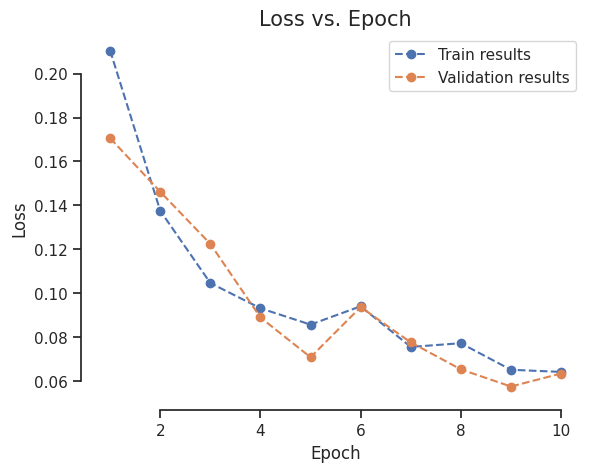

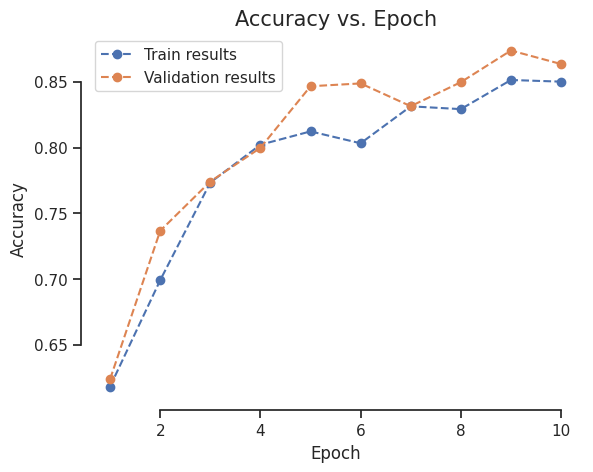

In [303]:
# train the model for 10 epochs, 
# after the training, check the plots to see how the model loss and metrics evolve,
# and to see predictions of the training data in real time

# Set up model:
model = UNet(in_channels = 1, out_channels = 1)
model = model.to(device)

n_epochs = 10
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = dice_score
train_losses, train_accs, val_losses, val_accs = run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs. Epoch', 'Accuracy', train_accs, val_accs)

## Evaluate on test data

Now, we will evaluate the **instance segmentation**  derived from the model predictions on the test data. To this end, we will use [connected components](https://en.wikipedia.org/wiki/Component_(graph_theory)#Algorithms) to convert the (binarized) network predictions into an instance segmentation. We will use the implementation from [skimage](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label).

**QUESTION**:
- Describe briefly what the connected components algorithm does when applied to a (binary) image. (You don't need to comment on the implementation).

TODO: your answer here

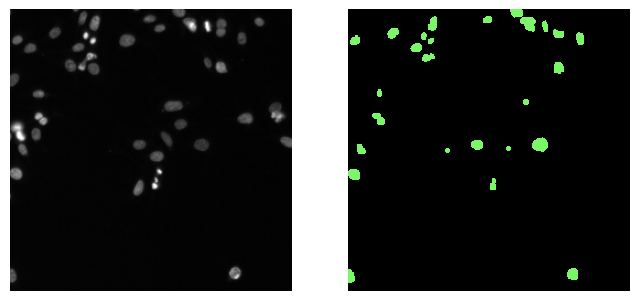

In [304]:
### TODO load and normalize the test images

image_paths = glob(os.path.join(data_folder, "test", "images", "*.tif"))
image_paths.sort()
mask_paths = glob(os.path.join(data_folder, "test", "masks", "*.tif"))
mask_paths.sort()
assert len(image_paths) == len(mask_paths)


im_no = len(image_paths)
test_images = [imageio.imread(image_paths[i]) for i in range(im_no) ]
test_masks = [imageio.imread(mask_paths[i]) for i in range(im_no) ]
test_images = [(im.astype("float32") - mean) / std for im in test_images]

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].axis("off")
ax[0].imshow(test_images[0], cmap="gray")
ax[1].axis("off")
ax[1].imshow(test_masks[0], cmap=get_random_colors(mask), interpolation="nearest")




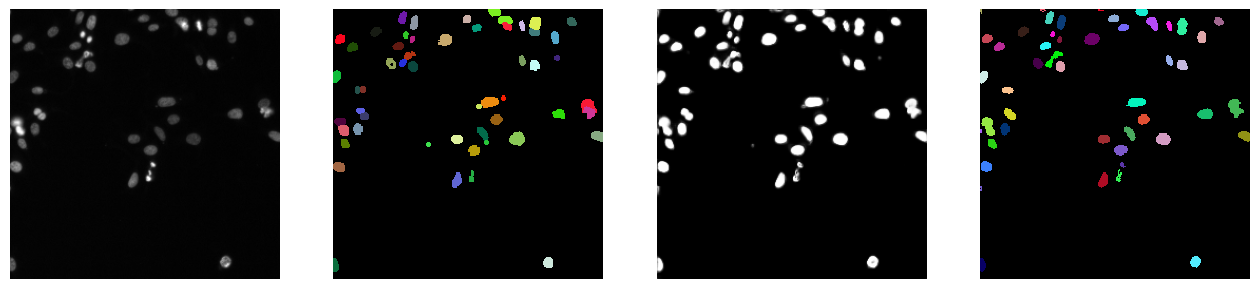

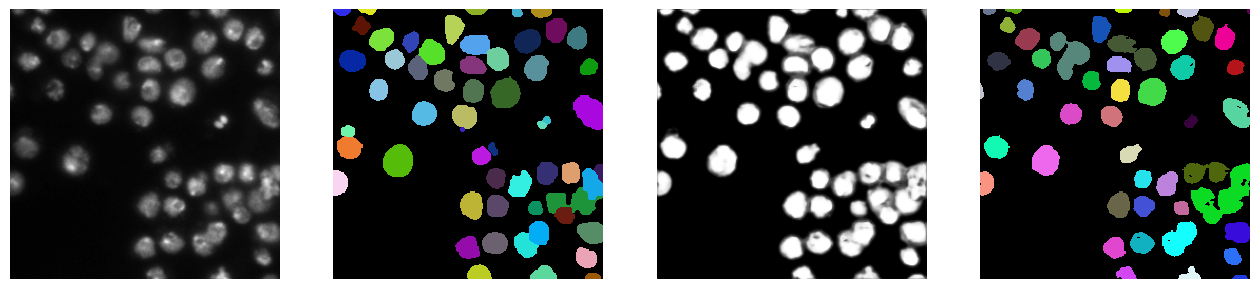

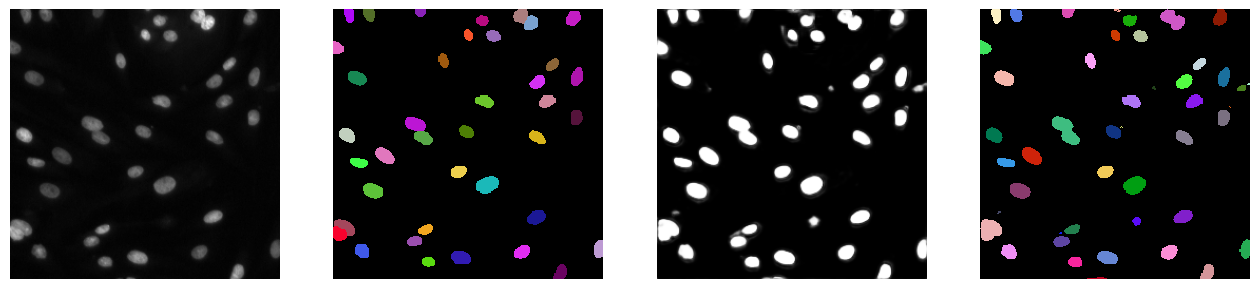

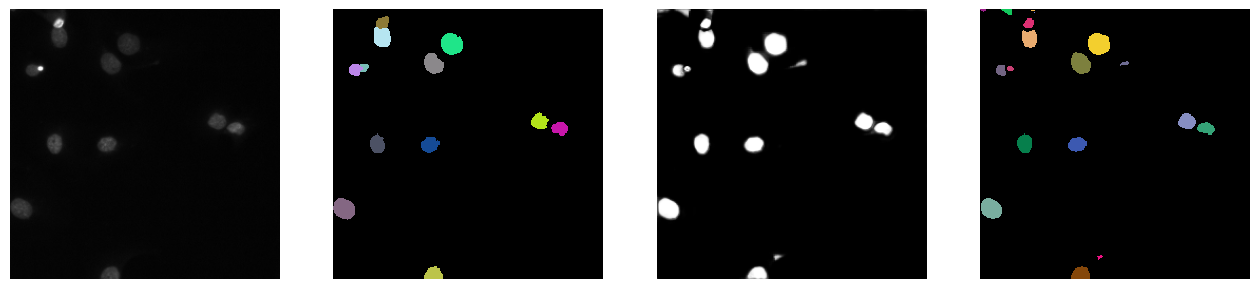

In [305]:
# check out instance segmentation for a few test images
counter = 0
with torch.no_grad():
    for im, mask in zip(test_images, test_masks):
        if counter > 3:
            break
        # predict with the model and apply sigmoid to map the prediction to the range [0, 1]
        pred = model(torch.from_numpy(im[None, None]).to(device))
        pred = torch.sigmoid(pred).cpu().numpy().squeeze()
        # get tbe nucleus instance segmentation by applying connected components to the binarized prediction
        nuclei = label(pred > 0.5)
        fig, ax = plt.subplots(1, 4, figsize=(16, 16))
        ax[0].axis("off")
        ax[0].imshow(im, cmap="gray")
        ax[1].axis("off")
        ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
        ax[2].axis("off")
        ax[2].imshow(pred, cmap="gray")
        ax[3].axis("off")
        ax[3].imshow(nuclei, cmap=get_random_colors(nuclei), interpolation="nearest")
        plt.show()
        counter += 1

To measure the segmentation quality we compute the intersection over union of each object in the prediction and each object in the ground-truth (if they overlap at all). We then find the best match between ground-truth and predicted objects and count all best matches above a given threshold (here 0.5) as true positives (TP). The objects in the the ground-truth that do not have a match are counted as false negatives (FN), the objects in the prediction that do not have a match as false positives (FP).

We can then compute the F1-Score based on TP, FP and FN and use it as evaluation criterion to compare the quality of instance segmentation results.

In [306]:
# compute f1 score based on true positives, false positives and false negatives
def f1(tp, fp, fn):
    return (2*tp)/(2*tp+fp+fn) if tp > 0 else 0


# compute the matches between predicted object (seg) and ground-truth objects (mask)
def compute_scores(seg, mask):
    # the contingency table function computes the overlap (intersection) between all objects in the two segmentations 
    overlap = contingency_table(seg, mask).toarray()
    # compute the total number of pixels for each object
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    # normalize the overlap by the union to compute the IOU
    eps = 1e-7
    ious = overlap / np.maximum(n_pixels_pred + n_pixels_true - overlap, eps)
    # ignore matches with zero (= background)
    ious = ious[1:, 1:]
    # compute the number of true objects (in mask), predicted object (in seg)
    # and the maximal number of matches (minimum of the too)
    n_pred, n_true = ious.shape
    n_matched = min(n_pred, n_true)
    return n_true, n_matched, n_pred, ious


# compute the true positives (= matches with a iou bigger than the threshold)
def compute_tps(ious, n_matched, threshold):
    not_trivial = n_matched > 0 and np.any(ious >= threshold)
    if not_trivial:
        # compute optimal matching with iou scores as tie-breaker
        costs = -(ious >= threshold).astype(float) - ious / (2*n_matched)
        pred_ind, true_ind = linear_sum_assignment(costs)
        assert n_matched == len(true_ind) == len(pred_ind)
        match_ok = ious[pred_ind, true_ind] >= threshold
        tp = np.count_nonzero(match_ok)
    else:
        tp = 0
    return tp


# compute the f1 score between predicted (seg) and ground-truth (mask) objects for the given threshold
def f1_score(seg, mask, threshold=0.5):
    if seg.sum() == 0:
        return 0.0
    n_true, n_matched, n_pred, scores = compute_scores(seg, mask)
    tp = compute_tps(scores, n_matched, threshold)
    fp = n_pred - tp
    fn = n_true - tp
    return f1(tp, fp, fn)

In [307]:
# Compute the average f1 score of all the test images
f1s = []
model.eval()
with torch.no_grad():
    for im, mask in tqdm.tqdm(zip(test_images, test_masks), total=len(test_images)):
        # the model can only predict images with a spatial size that is divisible by 16
        # if it isn't we just cat a few pixels to make it fit
        if any(sh % 16 != 0 for sh in im.shape):
            crop = tuple(
                slice(0, -(sh%16)) for sh in im.shape
            )
            im = im[crop]
            mask = mask[crop]
        input_ = torch.from_numpy(im[None, None]).to(device)
        pred = model(input_)
        pred = torch.sigmoid(pred).cpu().numpy().squeeze()
        labels = label(pred > 0.5)

        f1s.append(f1_score(labels, mask))
print()
# print(f1s)
print("Mean f1 score:", np.mean(f1s))

100%|██████████| 50/50 [00:01<00:00, 34.16it/s]


Mean f1 score: 0.763313721860341


**QUESTION**:
- Based on the examples you have visualized above, what are the biggest sources of error in the model predictions (instance segmentation)?
- How could these errors be addressed?

TODO your answer here

## Train with boundary channel

To avoid merges of touching nuclei, we will now add a boundary channel to the learning objective, and then use it for object separation in the instance segmentation funtion. To this end, we will train a U-Net that outputs 3 channels (background, foreground, object boundary) and use the cross entropy loss.

In [308]:
# TODO implement a transform that outputs an image with 3 values:
# 0 for backgorund, 1 for foreground (= nucleus) and 2 for boundary (boundary pixel between nucleus and background or between 2 nuclei)
# HINT: you can use skimage.segmentation.find_boundaries (already imported) to determine the boundary pixels

def label_transform(mask):
    # Initialize the output image with all pixels set to background (0)
    output = np.zeros(mask.shape)

    # Identify the foreground pixels (nuclei) and set them to 1
    output[mask > 0] = 1

    # Identify the boundary pixels between nuclei and background and set them to 2
    boundaries = find_boundaries(mask)
    output[boundaries] = 2

    return output



def label_split(mask):
    #transform = torchvision.transforms.Compose([ToTensor()])
    boundaries = find_boundaries(mask, connectivity=3)
    
    nucleus = np.zeros(mask.shape)
    nucleus[mask > 0] = 1
    nucleus[boundaries] = 0
    
    background = np.zeros(mask.shape)
    background[mask == 0] = 1
    background[boundaries] = 0
    
    return np.dstack((background, nucleus, boundaries))
    #print(type(transform(mask)))

In [309]:
def toTensor2(image, mask):    
    transform = transforms.ToTensor()
    image = transform(image)
    mask = transform(mask)
    return image, mask

In [310]:
def train_epoch(model, loader, loss, metric, optimizer):
    model.train()
    metric_list, loss_list = [], []
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        x, y = x.to(dtype=torch.float32).to(device), y.to(dtype=torch.float32).to(device)
        pred = model(x).to(dtype=torch.float32)
        loss_value = loss(pred, y)
        loss_value.backward()
        optimizer.step()
        loss_list.append(loss_value.item())
        if metric is not None:
            metric_value = metric(pred, y)
            metric_list.append(metric_value.item())

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None

In [311]:
class NucleiDataset2(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None, transform=None):
        assert len(images) == len(masks)
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.transform = transform

    def __getitem__(self, index):
        image, mask = self.images[index], self.masks[index]

        # crop the images to have the shape 256 x 256, so that we can feed them into memory
        # despite them having different sizes
        crop_shape = (256, 256)
        shape = image.shape
        if shape != crop_shape:
            assert image.ndim == mask.ndim == 2
            crop_start = [np.random.randint(0, sh - csh) if sh != csh else 0 for sh, csh in zip(shape, crop_shape)]
            crop = tuple(slice(cs, cs + csh) for cs, csh in zip(crop_start, crop_shape))
            image, mask = image[crop], mask[crop]
           
        # apply the transforms if given
        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
        if self.transform is not None:
            image, mask = self.transform(image, mask)
        
        # make sure we have numpy arrays and add a channel dimension for the image data
        #image, mask = np.array(image), np.array(mask)
        if image.ndim == 2:
            image = image[None]
            
        return image, mask
        
    def __len__(self):
        return len(self.images)
        

In [312]:
# instantiate the training and validation datasets with the new label transform
train_dataset = NucleiDataset2(
    train_images, train_masks, mask_transform=label_transform, transform = toTensor2)
val_dataset = NucleiDataset2(
    val_images, val_masks, mask_transform=label_transform, transform = toTensor2)

In [313]:
print(train_dataset[0][0].shape)

torch.Size([1, 256, 256])


torch.Size([1, 256, 256])


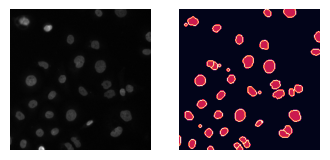

torch.Size([1, 256, 256])


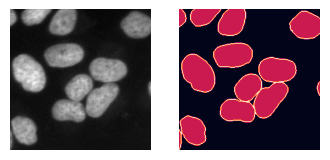

torch.Size([1, 256, 256])


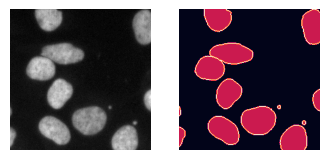

torch.Size([1, 256, 256])


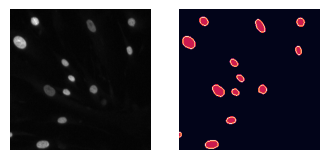

In [314]:
# visualize the new label transform and make sure it's correct
counter = 0
for im, target in train_dataset:
    if counter > 3:
        break
    fig, ax = plt.subplots(1, 2, figsize=(4, 4))
    print(target.shape)
    ax[0].axis("off")
    ax[0].imshow(im[0], cmap="gray")
    ax[1].axis("off")
    ax[1].imshow(target.squeeze())
    plt.show()
    counter += 1

In [315]:
# TODO instantiate the new unet and loss function
model = UNet(1,3).to(device)
loss = torch.nn.CrossEntropyLoss()

In [316]:
print(train_dataset[0][0].shape)

torch.Size([1, 256, 256])


In [317]:
type(train_dataset)

__main__.NucleiDataset2

In [318]:
# train the new U-Net for 10 epochs
# (we don't use a metric here, since the target (with class labels 0, 1, 2) and prediction (one-hot encoding) have different representations
n_epochs = 10
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=1)



optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = None
train_losses, _, val_losses, _ = run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [1, 1, 256, 256]

**Instance segmentation via watershed:**

We now want to use the predictions for background, foreground and boundary to better separate the nuclei than before using the following approach:
- Subtract the boundary prediction from the foreground prediction to separate touching nuclei from each other.
- Apply connected components to the result to get the "core" of the now separated nuclei.
- Grow these nucleus cores back to the full outlines.
    - For this step we will use the watershed algorithm, which segments images based on a height-map and markers.
    - The markers define the core of regions and they are grown by this algorithm until two markers meet at the highest point between them (defined by the heightmap).
- We will restrict the watershed to the foreground, so that nuclei don't spill over into the background. 

**Let's visualize these steps to better understand them:**

- We are given the foreground and boundary predictions from the model:

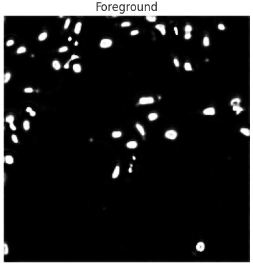 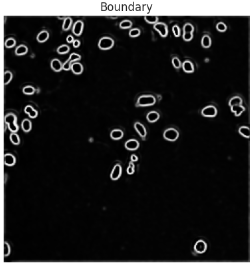

- Subtract the boundaries from the foreground predictions (left image), threshold the result (not shown) and apply connected components to generate the markers (right image):

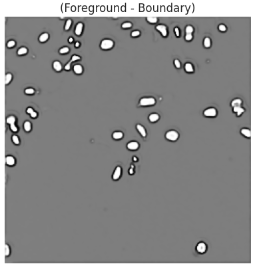 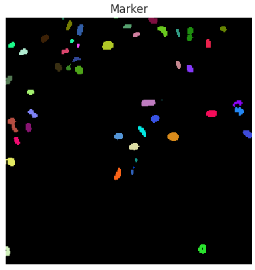

- This provides us with all three inputs for the watershed:
    - The boundary predictions from the network can be used as heightmap (because they separate the nuclei). (left image)
    - The markers that we have just computed (middle image)
    - The thresholded foreground predictions, which we use as mask for the watershed. (right image)

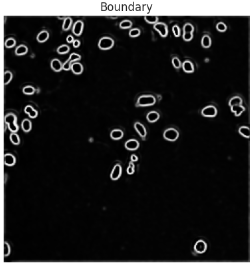 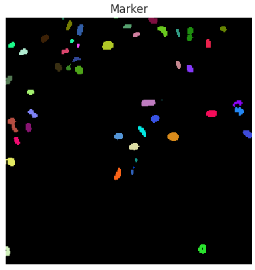 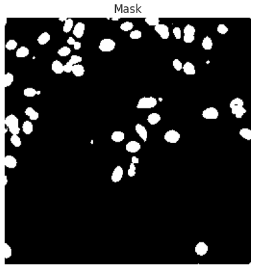


**Implementing the watershed:**

You can use `skimage.segmentation.watershed` (already imported) for this.

Here's how to use it:
```python
from skimage.segmentation import watershed

boundaries = ...
markers = ...
mask = ...

segmentation = watershed(image=boundaries, markers=markers, mask=mask)
```

In [ ]:
# TODO implement the watershed approach described above.
def instance_segmentation(foreground_prediction, boundary_prediction, threshold=0.5):
    
    foreground_prediction = foreground_prediction - boundary_prediction
    
    binary_mask = np.where(foreground_prediction >= threshold, 1, 0)
    labeled_components = label(binary_mask)
    instance_segmentation = watershed(-foreground_prediction, labeled_components, mask=binary_mask)
    
    return instance_segmentation

model = UNet(1,3).to(device)
loss = torch.nn.CrossEntropyLoss()

counter = 0
with torch.no_grad():
    for im, mask in zip(train_images, train_masks):
        if counter > 1:
            break
        input_ = torch.from_numpy(im[None, None]).to(device)
        print(input_.shape)
        pred = model(input_)
        pred = torch.softmax(pred, dim=1).cpu().numpy().squeeze()
        nuclei = instance_segmentation(pred[1], pred[2], threshold=0)

        fig, ax = plt.subplots(1, 3, figsize=(16, 16))
        ax[0].imshow(im)
        ax[0].axis("off")
        ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
        ax[1].axis("off")
        ax[2].imshow(nuclei, cmap=get_random_colors(nuclei), interpolation="nearest")
        ax[2].axis("off")
        plt.show()
        
        counter += 1


In [ ]:
# TODO check the prediction results and instance segmentation for a few images
# make sure your instance segmentation implementation is correct
# HINT: you need to apply a softmax to the network predictions 

In [ ]:
# TODO use the validation set to find a good value for the 'threshold' parameter in the instance_segmentation function
best_threshold = 

In [ ]:
# Compute the average f1 score of all the test images
f1s = []
model.eval()
with torch.no_grad():
    for im, mask in tqdm.tqdm(zip(test_images, test_masks), total=len(test_images)):
        # 
        if any(sh % 16 != 0 for sh in im.shape):
            crop = tuple(
                slice(0, -(sh%16)) for sh in im.shape
            )
            im = im[crop]
            mask = mask[crop]
        
        input_ = torch.from_numpy(im[None, None]).to(device)
        pred = model(input_)
        pred = torch.softmax(pred, dim=1).cpu().numpy().squeeze()
        assert pred.shape[0] == 3
        nuclei = instance_segmentation(pred[1], pred[2])

        f1s.append(f1_score(nuclei, mask, best_threshold))
print()
print(np.mean(f1s))

**QUESTIONS**:
- Did training with the boundaries and using them in the instance segmentation improve the results?
- Can you think of ways to improve the loss function for this learning task?

TODO your answers here

## Use the dice coefficient as loss function

Since our target is quite unbalanced (in particular the boundary channel), it is beneficial to use a loss function that is robust against class imbalance. In this part of the exercise we will use the Dice coefficient as loss. We have already used it as a metric before.

Note that we do not need to predict a channel for background when using the dice coefficient as a loss (unlike with Cross Entropy).

In [ ]:
# TODO implement a loss function based on the dice coefficient
# HINT: the dice coefficient is in range [0, 1] and higher values correspond to a better result
# Loss functions are minimized, so lower values should correspond to a better result

In [ ]:
# TODO implement and compare with different loss function variations

**QUESTIONS**:
- Did training with dice loss improve the results? Comment on it!

TODO your answers here

## [Optional] Try variations of the UNet architecture

- add BatchNorm
- replace TransposedConvs with bilinear upsampling and 1x1 convs
- use residual blocks instead of the normal convolutional blocks

In [ ]:
# TODO implement and compare u-net architecture variations

## [Optional] Train with data augmentation

- rotations & flips
- noise augmentations (add gaussian noise and/or poisson noise)
- crop and resize

Hint: use the `image_transform` (noise augmentations) and `transform` (geometrical augmentations) argument of the `NucleiDataset`

In [ ]:
# TODO implement data augmentations and compare with training without augmentations

# Denoising with Noise2Noise

Here, we implement [Noise2Noise](https://arxiv.org/abs/1803.04189), which is a method to learn image denoising **without** ground-truth, by using a different noisy image as target. Note that we are re-using the same architecture as before, which is a bit different from the one used in the paper.

## Data Preparation

We use the [VSDR dataset](https://cv.snu.ac.kr/research/VDSR), which contains 'clean' (i.e. without noise) natural images.

In [ ]:
# download the VSDR data
!conda install -y gdown
!gdown --id 1hNB5_MkxutrKLa1g35tSLCiq1J5xxH9F --folder

os.makedirs("/kaggle/working/dlforcv-ex4", exist_ok=True)

!unzip "/kaggle/working/VDSR/train_data.zip" -d "dlforcv-ex4/vsdr_train"
!unzip "/kaggle/working/VDSR/test_data.zip" -d "dlforcv-ex4/vsdr_test"

In [ ]:
# setting paths for the training and testing data
vsdr_train = "/kaggle/working/dlforcv-ex4/vsdr_train/"
vsdr_test = "/kaggle/working/dlforcv-ex4/vsdr_test/"

In [ ]:
# check the unique image sizes in the training data
image_exts = (".jpeg", ".jpg", ".png", ".bmp")
all_image_paths = [
    p for p in Path(vsdr_test).glob("**/*") if p.suffix.lower() in image_exts
]
shapes = []
for p in all_image_paths:
    shapes.append(imageio.imread(p).shape)
unique_shapes = list(set(shapes))
print(unique_shapes)

In [ ]:
# vsdr dataset that can deal with all the different data sizes in the training and test data
class VsdrDataset(Dataset):
    def __init__(self, root_dir, noise_transform):
        image_exts = (".jpeg", ".jpg", ".png", ".bmp")
        self.image_paths = [
            p for p in Path(root_dir).glob("**/*") if p.suffix.lower() in image_exts
        ]
        self.noise_transform = noise_transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        im = np.array(imageio.imread(self.image_paths[index]))
        if im.ndim == 2:
            im = np.concatenate([im[..., None]] * 3, axis=2)
        if im.shape[-1] == 1:
            im = np.concatenate([im] * 3, axis=2)
        target_shape = (256, 256)
        # first, pad the images if they are smaller than the target crop shape
        if any(sh < tsh for sh, tsh in zip(im.shape[:-1], target_shape)):
            padding = tuple((0, tsh - sh if sh < tsh else 0) for sh, tsh in zip(im.shape[:-1], target_shape))
            padding = padding + ((0, 0),)
            im = np.pad(im, padding, mode="reflect")
        # then crop tham if they are too large
        if any(sh > tsh for sh, tsh in zip(im.shape[:-1], target_shape)):
            crop_start = [np.random.randint(0, sh - tsh) if sh != tsh else 0 for sh, tsh in zip(im.shape[:-1], target_shape)]
            crop = tuple(slice(cs, cs + tsh) for cs, tsh in zip(crop_start, target_shape))
            im = im[crop]
        assert im.shape == (256, 256, 3), f"{im.shape}"
        
        # normalize the image to range [0, 1] (per channel)
        im = im.astype("float32")
        im -= im.min(axis=(0, 1), keepdims=True)
        im /= im.max(axis=(0, 1), keepdims=True)
        # bring image in range [-1, 1]
        im = 2 * im - 1
        
        # transform to channel first order
        im = im.transpose((2, 0, 1))
        # apply the noise transformation
        return self.noise_transform(im)

In [ ]:
# go from range [-1, 1] to [0, 255] and uint 8
# and go to channel last order
def to_display(im):
    im = (((im + 1) / 2) * 255).astype("uint8")
    return im.transpose((1, 2, 0))

In [ ]:
# sample a few images
check_dataset = VsdrDataset(vsdr_train, lambda x: x)
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for ii in range(16):
    im = check_dataset[ii]
    ax[ii % 4, ii // 4].axis("off")
    ax[ii % 4, ii // 4].imshow(to_display(im))
plt.show()

## Train a network with clean targets

As the first baseline, we will train a network with clean target data (i.e. without noise added to it). 

In [ ]:
# instatiate the model and loss function (Mean Squared Error)
model = UNet(in_channels=3, out_channels=3)
model.to(device)
loss = nn.MSELoss()
loss.to(device)

In [ ]:
# we will use the PSNR (peak signal to noise ratio) as metric to evaluate the predictions.
# you can read up on it and the implementation we are using here:
# https://www.ni.com/en-us/innovations/white-papers/11/peak-signal-to-noise-ratio-as-an-image-quality-metric.html
# (the higher the PSNR, the better)

def to_uint8(im):
    return torch.clamp((im + 0.5) * 255.0 + 0.5, 0, 255).type(torch.uint8)


class PSNR(nn.Module):
    def __call__(self, x, y):
        x, y = to_uint8(x), to_uint8(y)
        x, y = x.detach().cpu().numpy(), y.detach().cpu().numpy()
        return peak_signal_noise_ratio(x, y)

**QUESTION**:
- What does the PSNR metric measure?
- Why is it used instead of 'just' computing the pixel wise error (MSE)?

TODO your answer here

In [ ]:
# TODO implement a function that adds additive gaussian noise to the input
# the var argument should correspond to the variance of the gaussian
# HINT: you can use the function `random_noise` from scikit-image.
def additive_gaussian_noise(x, var):
    ...

In [ ]:
# TODO instantiate a vsdr dataset corresponding to the vsdr_train folder 
# with a noise transformation that returns a corrupted image (as network input)
# and a clean image (as target)
# use a variance of 0.1
# split the dataset into a train (90% of the data) and validation dataset (10%)
# HINT: you can use torch.utils.data.random_split to split a torch dataset
vsdr_train_ds =
vsdr_val_ds =

In [ ]:
# sample a few images from the train dataset
fig, ax = plt.subplots(3, 2, figsize=(16, 16))
for ii in range(3):
    noisy, clean = vsdr_train_ds[ii]
    # go back to uint8
    ax[ii, 0].axis("off")
    ax[ii, 0].imshow(to_display(noisy))
    ax[ii, 1].axis("off")
    ax[ii, 1].imshow(to_display(clean))
plt.show()

In [ ]:
# train the denoising network
n_epochs = 10
train_loader = DataLoader(vsdr_train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(vsdr_val_ds, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = PSNR()
train_losses, train_accs, val_losses, val_accs = run_training(model, train_loader, val_loader, loss, dice_score, optimizer, n_epochs)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs. Epoch', 'Accuracy', train_accs, val_accs)

In [ ]:
# create the test dataset
vsdr_test_ds = VsdrDataset(
    vsdr_test,
    noise_transform=lambda x: (additive_gaussian_noise(x, var=0.1), x)
)

In [ ]:
# TODO display some results on the test data

## Train a network with noisy targets (Gaussian noise)

Now, we train a network from noisy inputs AND noisy targets. And compare its results to the previous denoising network learned on clean targets.

QUESTION:
- Why can the model learn denoising even though we also have a noisy target?

TODO your answer here

In [ ]:
# instantiate new model and loss
model = UNet(in_channels=3, out_channels=3)
model.to(device)
loss = nn.MSELoss()
loss.to(device)

In [ ]:
# TODO create dataset with corrupted input and target
# use same variance as before (0.1)
vsdr_train_ds =
vsdr_val_ds =

In [ ]:
# train the model
n_epochs = 10
train_loader = DataLoader(vsdr_train_ds, batch_size=1, shuffle=True) 
val_loader = DataLoader(vsdr_val_ds, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = PSNR()
train_losses, train_accs, val_losses, val_accs = run_training(model, train_loader, val_loader, loss, dice_score, optimizer, n_epochs)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs. Epoch', 'Accuracy', train_accs, val_accs)

In [ ]:
# TODO show a few predictions for the test dataset

In [ ]:
# TODO compute the PSNR for the whole test dataset

**QUESTIONS**:
- Compare the result between the network trained with clean targets and with noisy targets.

TODO your answer here

## [Optional] Train a network with noisy targets (Poisson noise)

Use poisson noise instead of gaussian noise and compare to both the network trained with clean target and the network with the target corrupted by gaussian noise.

In [ ]:
# TODO run training with poisson noise and compare with previous results